~~~
Copyright 2026 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Chest X-ray anatomy localization with MedGemma 1.5

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/cxr_anatomy_localization_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogle-Health%2Fmedgemma%2Fmain%2Fnotebooks%2Fcxr_anatomy_localization_with_hugging_face.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/cxr_anatomy_localization_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This notebook demonstrates how to perform a localization task with MedGemma 1.5 using Hugging Face libraries. This notebook is for educational purposes only to show the baseline functionality of MedGemma 1.5. It does not represent a finished or approved product, is not intended to diagnose or suggest treatment for any disease or condition, and should not be used for medical advice. See HAI-DEF <a href='https://developers.google.com/health-ai-developer-foundations/terms?'>Terms of Use</a> for more information.

Before using MedGemma 1.5 for localization, thoroughly validate its performance. You may need to fine-tune the model to detect your specific object types within your target image modalities. The base model was trained and evaluated on CXR anatomical bounding box data from the [Chest ImaGenome](https://physionet.org/content/chest-imagenome/1.0.0/) dataset.

## Setup

To complete this tutorial, you'll need to have a runtime with [sufficient resources](https://ai.google.dev/gemma/docs/core#sizes) to run the MedGemma model.

You can try out MedGemma 1.5 4B for free in Google Colab using a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Get access to MedGemma

Before you get started, make sure that you have access to MedGemma models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedGemma model page](https://huggingface.co/google/medgemma-1.5-4b-it) and accept the usage conditions.

### Authenticate with Hugging Face

Generate a Hugging Face `read` access token by going to [settings](https://huggingface.co/settings/tokens).

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [ ]:
import os
import sys

google_colab = "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT")

if google_colab:
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

### Install dependencies

In [ ]:
! pip install --upgrade --quiet accelerate transformers

## Load model from Hugging Face Hub

In [ ]:
from transformers import pipeline
import torch

model_id = "google/medgemma-1.5-4b-it"

model_kwargs = dict(
    dtype=torch.bfloat16,
    device_map="auto",
)

pipe = pipeline("image-text-to-text", model=model_id, model_kwargs=model_kwargs)

## Run inference

### Specify image and prompt

In [ ]:
import os
from PIL import Image

object_name = "right clavicle"  # @param {type: "string"}

prompt = f"""Instructions:
The following user query will require outputting bounding boxes. The format of bounding boxes coordinates is [y0, x0, y1, x1] where (y0, x0) must be top-left corner and (y1, x1) the bottom-right corner. This implies that x0 < x1 and y0 < y1. Always normalize the x and y coordinates the range [0, 1000], meaning that a bounding box starting at 15% of the image width would be associated with an x coordinate of 150. You MUST output a single parseable json list of objects enclosed into ```json...``` brackets, for instance ```json[{{"box_2d": [800, 3, 840, 471], "label": "car"}}, {{"box_2d": [400, 22, 600, 73], "label": "dog"}}]``` is a valid output. Now answer to the user query.

Remember "left" refers to the patient's left side where the heart is and sometimes underneath an L in the upper right corner of the image.

Query:
Where is the {object_name}? Don't give a final answer without reasoning. Output the final answer in the format "Final Answer: X" where X is a JSON list of objects. The object needs a "box_2d" and "label" key. Answer:"""

# Image attribution: Stillwaterising, CC0, via Wikimedia Commons
image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"  # @param {type: "string"}
! wget -nc -q {image_url}
image_filename = os.path.basename(image_url)
image = Image.open(image_filename)

### Preprocess image

Pad the input image to a square format. This maintains consistency with the original preprocessing in model training and evaluation.


In [ ]:
import numpy as np
import skimage


def pad_image_to_square(image_array):
    # Convert image to unsigned byte format and handle grayscale/RGBA images.
    image_array = skimage.util.img_as_ubyte(image_array)
    if len(image_array.shape) < 3:
        image_array = skimage.color.gray2rgb(image_array)
    if image_array.shape[2] == 4:
        image_array = skimage.color.rgba2rgb(image_array)

    # Pad the image to a square shape.
    h = image_array.shape[0]
    w = image_array.shape[1]
    max_dim = max(h, w)
    if h < w:
        dh = w - h
        image_array = np.pad(
            image_array, ((dh // 2, dh - dh // 2), (0, 0), (0, 0))
        )
    if w < h:
        dw = h - w
        image_array = np.pad(
            image_array, ((0, 0), (dw // 2, dw - dw // 2), (0, 0))
        )
    return image_array


preprocess_image = True  # @param {type: "boolean"}

if preprocess_image:
    # Convert the input image to a square numpy array and normalize pixel values.
    image_array = (pad_image_to_square(image) * 255).astype(np.uint8)
    # Convert the numpy array back to a PIL Image.
    image = Image.fromarray(image_array)

### Run model with the `pipeline` API

---

**[ User ]**

Instructions:
The following user query will require outputting bounding boxes. The format of bounding boxes coordinates is [y0, x0, y1, x1] where (y0, x0) must be top-left corner and (y1, x1) the bottom-right corner. This implies that x0 < x1 and y0 < y1. Always normalize the x and y coordinates the range [0, 1000], meaning that a bounding box starting at 15% of the image width would be associated with an x coordinate of 150. You MUST output a single parseable json list of objects enclosed into ```json...``` brackets, for instance ```json[{"box_2d": [800, 3, 840, 471], "label": "car"}, {"box_2d": [400, 22, 600, 73], "label": "dog"}]``` is a valid output. Now answer to the user query.

Remember "left" refers to the patient's left side where the heart is and sometimes underneath an L in the upper right corner of the image.

Query:
Where is the right clavicle? Don't give a final answer without reasoning. Output the final answer in the format "Final Answer: X" where X is a JSON list of objects. The object needs a "box_2d" and "label" key. Answer:

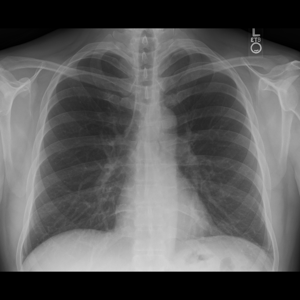

---

**[ MedGemma ]**

Final Answer: ```json[{"box_2d": [140, 110, 340, 470], "label": "right clavicle"}]```

---

In [ ]:
from IPython.display import display, Markdown

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt}
        ]
    }
]

output = pipe(text=messages, max_new_tokens=1000, do_sample=False)
response = output[0]["generated_text"][-1]["content"]

# Note that the model may think even without being prompted to. Remove the
# thinking trace generated between special tokens <unused94> and <unused95>.
if "<unused95>" in response:
    response = response.split("<unused95>", 1)[1].lstrip()

display(Markdown(f"---\n\n**[ User ]**\n\n{prompt}"))
display(image.resize((300, 300)))
display(Markdown(f"---\n\n**[ MedGemma ]**\n\n{response}\n\n---"))

### Draw bounding box

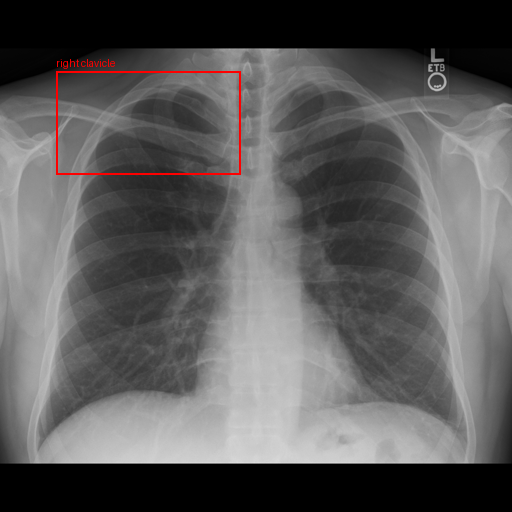

In [ ]:
import json
from PIL import ImageDraw, ImageFont

# Extract the JSON string from the response
json_start = response.find("```json")
json_end = response.rfind("```")
if json_start != -1 and json_end != -1:
    json_str = response[json_start + len("```json"):json_end].strip()
    bbox_data = json.loads(json_str)
else:
    bbox_data = []
    print("Bounding box JSON object could not be parsed.")

draw_image = image.copy()
image_width, image_height = draw_image.size

# Scale the image to 512px width
new_width = 512
new_height = int(image_height * (new_width / image_width))
scaled_image = draw_image.resize((new_width, new_height))

# Create a drawable image
draw = ImageDraw.Draw(scaled_image)

for item in bbox_data:
    box_2d = item.get("box_2d")
    label = item.get("label")

    if box_2d:
        # Coordinates are [y0, x0, y1, x1] and normalized to [0, 1000]
        y0, x0, y1, x1 = box_2d

        # Convert bounding box coordinates from normalized to unnormalized
        unnormalized_x0 = x0 / 1000 * new_width
        unnormalized_y0 = y0 / 1000 * new_height
        unnormalized_x1 = x1 / 1000 * new_width
        unnormalized_y1 = y1 / 1000 * new_height

        # Draw the rectangle
        draw.rectangle(
            [(unnormalized_x0, unnormalized_y0), (unnormalized_x1, unnormalized_y1)],
            outline="red",
            width=2,
        )
        # Optionally, add label text
        if label:
            draw.text(
                (unnormalized_x0, unnormalized_y0 - 15), # Position text above the box
                label,
                fill="red",
            )

# Display the scaled image with bounding box
display(scaled_image)

## Next steps

Explore the other [notebooks](https://github.com/google-health/medgemma/blob/main/notebooks) to learn what else you can do with the model.